In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import obspy as op
import scipy as sp
#from salvus import namespace as sn
from obspy.geodetics.base import gps2dist_azimuth
from scipy.stats import pearsonr

#sp = sn.Project(path="CANV_FULL")
#wus = sn.Project(path='CANV256')
#cs = sn.Project(path='CANV_CSEM')

#start = sn.Project(path = 'CSEM_RETEST')

# Part 1: Define Functions 

We'll define a set of functions that will streamline processing the data later on.
1. `grab_event_data`: a function to point to the correct directories in the Salvus project(s) where the wavefomr data is stored. We also grab the observed data from one of the projects. The function outputs Salvus event waveform objects that we'll unwrap later.

2. `peak_to_peak`: calcualtes the peak-to-peak signal to noise ratio (SNR) of our data. We'll run this function on our observed data to exclude noisy waveforms.

3. `create_streams`: unwraps the Salvus event waveform objects into ObsPy Streams that we can calculate the envelopes for. This function also includes a few preprocessing steps: calculating the distance and backazimuth for a given station-event pair, decimating the data to 2 samples per second, filter waveforms to the desired period band, slice the data so that all traces are the same length, remove station-event pairs with low SNR, convert the amplitude into units of microns, and rotate the data into the ZRT coordinate system.

4. `envelope_xcorr`: compute the envelopes of the data in all three components, then compute the Pearson cross-correlation coefficient for the models vs. the observed data. The cross-correlation values are then appended to lists for each model and component.

In [5]:
lat_min = 31.5
lat_max = 43
lon_min = -125.0
lon_max = -114.0

def grab_event_data(event_name):
    event_name = event_name

    data_processing_config_name = "20_80_seconds"
    data = wus.waveforms.get(data_name='PROCESSED_DATA:'+data_processing_config_name, events=event_name)

    # #SPiRaL Initial Model
    simulation_config_name = 'spiral_20_mesh'
    spiral = sp.waveforms.get(data_name=simulation_config_name, events=event_name)

    # #WUS_AWT
    simulation_config_name = 'wus'
    wus256 = start.waveforms.get(data_name=simulation_config_name, events=event_name)
    
    #CSEM
    simulation_config_name = 'csem'
    csem = start.waveforms.get(data_name=simulation_config_name, events=event_name)

    #CANV_SP
    simulation_config_name = sp.inversions.get_simulation_name(
            inverse_problem_configuration= "inversion_1_r2", iteration_id = 13)
    canv_sp = sp.waveforms.get(data_name= simulation_config_name, events=event_name)

    #CANV256
    simulation_config_name = wus.inversions.get_simulation_name(
            inverse_problem_configuration= "inversion_2_fixed", iteration_id = 26)
    canv_wus = wus.waveforms.get(data_name=simulation_config_name, events=event_name)
    
    #CANV_CS
    simulation_config_name = cs.inversions.get_simulation_name(
            inverse_problem_configuration= "inversion_2_r2", iteration_id = 23)
    canv_cs = cs.waveforms.get(data_name=simulation_config_name, events=event_name)
    
    return data, spiral, wus256, csem, canv_sp, canv_wus, canv_cs

In [6]:
def peak_to_peak(trace, freqmin):
    t = trace.times()
    y = trace.data
    
    win_len = 1/freqmin
    w0 = 0
    w1 = t[t<win_len].max()
    tmax = t.max()
    p2p = []
    while w1 < tmax:
        index = (t>=w0) & (t<(w0+win_len))
        w0 = t[index].max()
        w1 = w0 + win_len
        p2p.append(y[index].max() - y[index].min())

    try:
        p2p = max(p2p)
    except ValueError:
        p2p = y.max() - y.min()
        
    return p2p

In [7]:
def create_streams(event_name, sta_lat, sta_lon, st, st_name, filter_wfs, snr_calc, wf_return):
    from obspy.core import UTCDateTime
    """
    Plot data and two sets of synthetic waveforms (3-components)
    Inputs:
        event = Salvus event object
        st = data stream
        st1 = 1st synthetic stream, e.g. starting model
        st2 = 2nd synthetic stream, e.g. inversion model
        Assumes the streams are for the same event and receiver and have all 3 components
    """
    
    event = sp.events.get(event_name=event_name)
    max_period = 80
    min_period = 20
    filter_wfs = True
    filter_period = 80
    if filter_wfs:
        max_period = filter_period
    
    eve_meta = event.sources[0]._initial_arguments
    eve_lat = eve_meta['latitude']
    eve_lon = eve_meta['longitude']
    
    azi = gps2dist_azimuth(sta_lat,sta_lon, eve_lat,eve_lon)
    bazi = azi[2]
    
    # Origin time
    origin_time = UTCDateTime(event.sources[0]._initial_arguments['reference_time_utc_string'])
    
    # Interpolate waveforms to common sample_Rate
    target_sps = 2
    st.interpolate(sampling_rate=target_sps)

    # Additional highpass filter
    if filter_wfs:
        st.filter(type='bandpass', freqmin=1/filter_period, freqmax=1/min_period)
    t0 = origin_time
    t1 = origin_time + azi[0]/8500.
    t2 = origin_time + azi[0]/8000.
    t3 = origin_time + azi[0]/2500.
    
    # Arrange order of stream components to ZNE
    st = st.select(component="Z") + st.select(component="N") + st.select(component="E")

    # Scale amplitudes from meters to micrometers
    for tr in st:
        tr.data = tr.data * 1.0e6
        tr.stats.distance = azi[0]/1000. #distance in km

    st.rotate(method = 'NE->RT', back_azimuth = bazi)
    min_freq = 1./max_period
    
    if snr_calc:
        for tr in st:
            if tr.stats.channel == 'BHR' or 'HHR':
                p2pn = peak_to_peak(tr.slice(origin_time, t1), min_freq)
                p2ps = peak_to_peak(tr.slice(t2, t3), min_freq)
                snr = 10*np.log10(p2ps**2/p2pn**2)
                if snr >=10.0:
                    SNR[sncl] = snr, [sta_lat, sta_lon]
        return SNR
    if wf_return:
        # Cut waveforms to tmax
        stream = st_name
        for tr in st:
            stream.append(tr)
        stream = stream.slice(starttime=t2, endtime=t3)
        return stream

In [8]:
def envelope_xcorr(obs, start, final, start_xcorrs, final_xcorrs):
    #calculate envelopes for the data
    obs_env = op.signal.filter.envelope(obs.data)

    #calculate envelopes for the starting model waveforms
    start_env = op.signal.filter.envelope(start.data)
    
    #calculate envelopes for the final model waveforms
    final_env = op.signal.filter.envelope(final.data)
    
    #Cross-correlate the envelopes for each component
    try:
        start_corr, _ = pearsonr(obs_env, start_env)
        final_corr, _ = pearsonr(obs_env, final_env)
        start_xcorrs.append(start_corr)
        final_xcorrs.append(final_corr)
    except:
        print('ValueError: array must not contain infs or NaNs')
        pass

    
    #Append correlation values to lists based on model and component

In [64]:
wus_xcorrs = []
cnws_xcorrs = []

sp_xcorrs = []
cnsp_xcorrs = []

cs_xcorrs = []
cncs_xcorrs = []

for event_name in wus.events.list():
    print(event_name)
    data, spiral, wus256, csem, canv_sp, canv_wus, canv_cs = grab_event_data(event_name)
    
    sta_lats = []
    sta_lons = []
    sncls = []
    for  idx in np.arange(0, len(data[0].receiver_name_list), 1):   
        sta = data[0].receivers[idx].to_json()
        args = sta['arguments']
        sta_lat = sta_lat = converted_latitude = (
        # This function defaults to the WGS84 ellipsoid but others are possible.
        sn.simple_config.coordinate_system_utils._geocentric_to_elliptic_latitude(
            lat=args['latitude']
        )
    )
        sta_lon = args['longitude']
        sta_lats.append(sta_lat)
        sta_lons.append(sta_lon)

        sncl = str(args['network_code']+'.'+ args['station_code']+'.')
        sncls.append(sncl)

    SNR = {}

    for sncl in sncls:
        try:
            st_data = data[0].get_receiver_data(receiver_name=sncl, 
                                                receiver_field='displacement')
            SNR = create_streams(event_name, sta_lat, sta_lon, st_data, obs, True, True, False)
        except:
            pass

    st_sp = op.Stream()
    st_cnsp = op.Stream()
    st_wus = op.Stream()
    st_cnws = op.Stream()
    st_cs = op.Stream()
    st_cncs = op.Stream()
    obs = op.Stream()


    for key, value in SNR.items():
        sta_lat = value[1][0]
        sta_lon = value[1][1]
        
        try:

            st_start_s = spiral[0].get_receiver_data(receiver_name=key, 
                                                     receiver_field='displacement')
            st_final_s = canv_sp[0].get_receiver_data(receiver_name=key, 
                                                      receiver_field='displacement')
            st_start_w = wus256[0].get_receiver_data(receiver_name=key, 
                                                     receiver_field='displacement')
            st_final_w = canv_wus[0].get_receiver_data(receiver_name=key, 
                                                       receiver_field='displacement')
            st_start_c = csem[0].get_receiver_data(receiver_name=key, 
                                                   receiver_field='displacement')
            st_final_c = canv_cs[0].get_receiver_data(receiver_name=key, 
                                                      receiver_field='displacement')
            st_data = data[0].get_receiver_data(receiver_name=key, 
                                                receiver_field='displacement')

            st_sp = create_streams(event_name, sta_lat, sta_lon, st_start_s, st_sp, 
                                   True, False, True)
            st_cnsp = create_streams(event_name, sta_lat, sta_lon, st_final_s, st_cnsp,
                                    True, False, True)
            st_wus = create_streams(event_name, sta_lat, sta_lon, st_start_w, st_wus, 
                                    True, False, True)
            st_cnws = create_streams(event_name, sta_lat, sta_lon, st_final_w, st_cnws, 
                                     True, False, True)
            st_cs = create_streams(event_name, sta_lat, sta_lon, st_start_c, st_cs, 
                                   True, False, True)
            st_cncs = create_streams(event_name, sta_lat, sta_lon, st_final_c, st_cncs, 
                                     True, False, True)
            obs = create_streams(event_name, sta_lat, sta_lon, st_data, obs, 
                                 True, False, True)
        except:
            print('SPiRaL Issue')
            
   # print(len(st_sp), len(st_cnsp), len(st_wus), len(st_cnws), len(st_cs), len(st_cncs))

#     if len(obs) != len(st_sp):
#         n = len(st_sp)-len(obs)
#         if n != 0:
#             n = len(st_sp)-len(obs)
#             for idx in np.arange(0, len(obs)):
#                 if obs[idx].id[:-4] == st_wus[idx].id[:-4]:
#                     pass
#                 else:
#                     st_sp.remove(st_sp[idx])
#                     st_cnsp.remove(st_cnsp[idx])
#                     st_wus.remove(st_wus[idx])
#                     st_cnws.remove(st_cnws[idx])
#                     st_cs.remove(st_cs[idx])
#                     st_cncs.remove(st_cncs[idx])
#                     break
    
    for idx in np.arange(0, len(st_sp)):
        try:
            envelope_xcorr(obs[idx], st_sp[idx], st_cnsp[idx], sp_xcorrs, cnsp_xcorrs)
            envelope_xcorr(obs[idx], st_wus[idx], st_cnws[idx], wus_xcorrs, cnws_xcorrs)
            envelope_xcorr(obs[idx], st_cs[idx], st_cncs[idx], cs_xcorrs, cncs_xcorrs)
        #print('Done!')
        except:
            print('ValueError: operands could not be broadcast together with mismatched shapes')

event_BAJA_CALIFORNIA_MEXICO_Mag_4.85_2010-04-15-10-20


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: operands could not be broadcast together with mismatched shapes
event_BAJA_CALIFORNIA_MEXICO_Mag_4.86_2010-09-20-00-30


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could n

 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities diffe

SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
event_BAJA_CALIFORNIA_MEXICO_Mag_5.03_2010-09-14-10-52


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


SPiRaL Issue
SPiRaL Issue


SPiRaL Issue


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadc

 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together wit

 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


SPiRaL Issue
SPiRaL Issue
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_4.84_2008-02-20-01-28


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_4.84_2010-12-11-12-52


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
Valu

 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


SPiRaL Issue
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_4.86_2010-05-08-18-46


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ValueError: operands could not be broadcast together with mismatched shapes
event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_4.91_2008-02-22-19-31


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


SPiRaL Issue
SPiRaL Issue


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_4.97_2010-05-08-18-33


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ValueError: operands could not be broadcast together with mismatched shapes
event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_4.98_2010-04-05-13-33


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


SPiRaL Issue
SPiRaL Issue
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_5.01_2020-10-01-00-31


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

ValueError: operands could not be broadcast together with mismatched shapes
event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_5.03_2008-02-12-04-32


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_5.04_2004-06-15-22-28


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_5.06_2010-05-22-17-31


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_5.11_2008-02-19-22-41


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
ValueError: operands could not be broadcast together with mismatched shapes
event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_5.14_2008-02-11-18-29


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
Va

/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_5.17_2009-09-19-22-55


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_5.29_2006-05-24-04-20


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 0]):
	norm_resp; zero stage gain,
	skipping to next response now


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_5.37_2010-04-08-16-44


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is cons

ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_5.41_2012-08-26-19-31


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_5.47_2002-02-22-19-32


event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_5.49_2012-08-26-20-58


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs 

 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_5.87_2009-12-30-18-49


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_4.67_2020-04-11-16-22


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_4.83_2020-08-19-17-32


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_4.88_2009-10-03-01-09


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_4.91_2016-02-16-23-04


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_4.93_2015-02-14-02-29


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities diffe

SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_5.14_2009-10-01-10-01


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_5.23_2009-10-03-01-16


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_5.26_2013-02-13-00-10


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_5.26_2020-04-11-14-36


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_5.37_2004-09-18-23-43


event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_5.39_2004-09-18-23-02


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_5.59_2016-12-28-08-22


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_5.69_2016-12-28-08-18


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_5.72_2016-12-28-09-13


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_5.84_2020-06-24-17-40


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

event_CENTRAL_CALIFORNIA_Mag_4.64_2019-10-15-05-33


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/core/inventory/network.py:249: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (

ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs 

ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs 

 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
event_CENTRAL_CALIFORNIA_Mag_4.82_2011-08-27-07-18


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: 

 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/core/inventory/network.py:249: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (

ValueError: operands could not be broadcast together with mismatched shapes
event_CENTRAL_CALIFORNIA_Mag_4.94_2004-09-30-18-54


event_CENTRAL_CALIFORNIA_Mag_4.95_2016-02-24-00-02


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

event_CENTRAL_CALIFORNIA_Mag_5.02_2004-09-29-22-54


event_CENTRAL_CALIFORNIA_Mag_5.06_2019-08-22-20-49


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


event_CENTRAL_CALIFORNIA_Mag_5.07_2004-09-29-17-10
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CENTRAL_CALIFORNIA_Mag_5.38_2012-10-21-06-55


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CENTRAL_CALIFORNIA_Mag_5.43_2019-07-05-11-07


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

SPiRaL Issue


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


ValueError: operands could not be broadcast together with mismatched shapes
event_CENTRAL_CALIFORNIA_Mag_5.56_2007-10-31-03-04


event_CENTRAL_CALIFORNIA_Mag_5.57_2020-06-04-01-32


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_CENTRAL_CALIFORNIA_Mag_5.97_2004-09-28-17-15


event_CENTRAL_CALIFORNIA_Mag_6.45_2019-07-04-17-33


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

event_GULF_OF_CALIFORNIA_Mag_4.86_2010-04-06-08-12


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


event_GULF_OF_CALIFORNIA_Mag_5.60_2020-03-07-03-52


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

ValueError: operands could not be broadcast together with mismatched shapes
event_NEAR_COAST_OF_NORTHERN_CALIF._Mag_4.88_2005-03-18-07-24


ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together

 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

event_NEAR_COAST_OF_NORTHERN_CALIF._Mag_4.99_2009-08-07-10-49


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_NEAR_COAST_OF_NORTHERN_CALIF._Mag_5.05_2007-06-25-02-32


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_NEAR_COAST_OF_NORTHERN_CALIF._Mag_5.05_2008-10-26-09-27
SPiRaL Issue
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_NEAR_COAST_OF_NORTHERN_CALIF._Mag_5.27_2002-06-17-16-55


event_NEAR_COAST_OF_NORTHERN_CALIF._Mag_5.30_2020-03-18-22-08


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


event_NEAR_COAST_OF_NORTHERN_CALIF._Mag_5.42_2007-02-26-12-20


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_NEAR_COAST_OF_NORTHERN_CALIF._Mag_5.65_2019-06-23-03-53


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

event_NEAR_COAST_OF_NORTHERN_CALIF._Mag_5.76_2015-01-28-21-09


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities diffe

ValueError: operands could not be broadcast together with mismatched shapes
event_NEVADA_Mag_4.71_2020-05-16-11-50


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

event_NEVADA_Mag_4.79_2020-05-22-00-22


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

ValueError: operands could not be broadcast together with mismatched shapes
event_NEVADA_Mag_4.87_2020-06-08-03-24


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

event_NEVADA_Mag_4.90_2015-09-14-13-55


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

SPiRaL Issue
SPiRaL Issue


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
event_NEVADA_Mag_4.91_2020-05-20-12-36


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

event_NEVADA_Mag_5.01_2008-04-26-06-40


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_NEVADA_Mag_6.02_2008-02-21-14-16


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_NEVADA_Mag_6.47_2020-05-15-11-03


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

ValueError: operands could not be broadcast together with mismatched shapes
event_NORTHERN_CALIFORNIA_Mag_4.84_2006-05-12-10-37


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 0]):
	norm_resp; zero stage gain,
	skipping to next response now


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_NORTHERN_CALIFORNIA_Mag_4.88_2016-07-21-23-09


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

event_NORTHERN_CALIFORNIA_Mag_4.90_2011-10-27-06-37


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array

/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_NORTHERN_CALIFORNIA_Mag_5.08_2016-08-10-02-57


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

event_NORTHERN_CALIFORNIA_Mag_5.14_2016-12-14-16-41


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_NORTHERN_CALIFORNIA_Mag_5.17_2001-08-10-20-19
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not c

ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_NORTHERN_CALIFORNIA_Mag_5.62_2012-02-13-21-07


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


event_NORTHERN_CALIFORNIA_Mag_5.72_2013-05-24-03-47


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])
 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: 

 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities diffe

ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: 

event_SOUTHERN_CALIFORNIA_Mag_4.94_2013-05-29-14-38


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])
 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_SOUTHERN_CALIFORNIA_Mag_4.98_2009-03-24-11-55


SPiRaL Issue
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_SOUTHERN_CALIFORNIA_Mag_5.02_2020-04-04-01-53


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

event_SOUTHERN_CALIFORNIA_Mag_5.13_2008-12-06-04-18


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_SOUTHERN_CALIFORNIA_Mag_5.15_2005-09-02-01-27


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_SOUTHERN_CALIFORNIA_Mag_5.15_2014-03-29-04-09


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip

SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
event_SOUTHERN_CALIFORNIA_Mag_5.21_2005-06-12-15-41


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_SOUTHERN_CALIFORNIA_Mag_5.27_2016-06-10-08-04


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

event_SOUTHERN_CALIFORNIA_Mag_5.36_2018-04-05-19-29


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

event_SOUTHERN_CALIFORNIA_Mag_5.46_2008-07-29-18-42


/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_SOUTHERN_CALIFORNIA_Mag_5.54_2010-07-07-23-53


 EVRESP ERROR (... [File: <stdin>; Start date: ; Stage: 3]):
	check_channel; units mismatch between stages,
	skipping to next response now
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:142: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / np.clip(w, np.spacing(1), w.max())
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/obspy/signal/interpolation.py:146: RuntimeWarning: invalid value encountered in multiply
  slope[1:-1] = (w[:-1] * m[:-1] + w[1:] * m[1:]) / (w[:-1] + w[1:])


ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_SOUTHERN_NEVADA_Mag_4.97_2015-05-22-18-47


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

SPiRaL Issue
SPiRaL Issue
SPiRaL Issue


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
SPiRaL Issue
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
ValueError: operands could not be broadcast together with mismatched shapes
event_W._ARIZONA-SONORA_BORDER_REGION_Mag_5.75_2001-12-08-23-36


In [68]:
import pandas as pd

df = pd.DataFrame([sp_xcorrs, wus_xcorrs, cs_xcorrs, cnsp_xcorrs, cnws_xcorrs, cncs_xcorrs])

df.to_csv('Envelope_xcorr_Vals.csv')

In [2]:
import pandas as pd

df = pd.read_csv('Evelope_xcorr_Vals.csv')


sp_xcorrs = []
wus_xcorrs = []
cs_xcorrs = []
cnsp_xcorrs = []
cnws_xcorrs = []
cncs_xcorrs = []

for row in range(0,6):
    for col in range(0, 59452):
        value = df.loc[row,str(col)]
        if row == 0:
            if value >= 0.0:
                sp_xcorrs.append(value)
        elif row == 1:
            if value >= 0.0:
                wus_xcorrs.append(value)
        elif row == 2:
            if value >= 0.0:
                cs_xcorrs.append(value)
        elif row == 3:
            if value >= 0.0:
                cnsp_xcorrs.append(value)
        elif row == 4:
            if value >= 0.0:
                cnws_xcorrs.append(value)
        else:
            if value >= 0.0:
                cncs_xcorrs.append(value)

In [3]:
import pandas as pd

df = pd.read_csv('Validation_Evelope_xcorr_Vals.csv')

sp_xcorrs_val = []
wus_xcorrs_val = []
cs_xcorrs_val = []
cnsp_xcorrs_val = []
cnws_xcorrs_val = []
cncs_xcorrs_val = []

for row in range(0,6):
    for col in range(0, 10398):
        value = df.loc[row,str(col)]
        if row == 0:
            if value >= 0.0:
                sp_xcorrs_val.append(value)
        elif row == 1:
            if value >= 0.0:
                wus_xcorrs_val.append(value)
        elif row == 2:
            if value >= 0.0:
                cs_xcorrs_val.append(value)
        elif row == 3:
            if value >= 0.0:
                cnsp_xcorrs_val.append(value)
        elif row == 4:
            if value >= 0.0:
                cnws_xcorrs_val.append(value)
        else:
            if value >= 0.0:
                cncs_xcorrs_val.append(value)

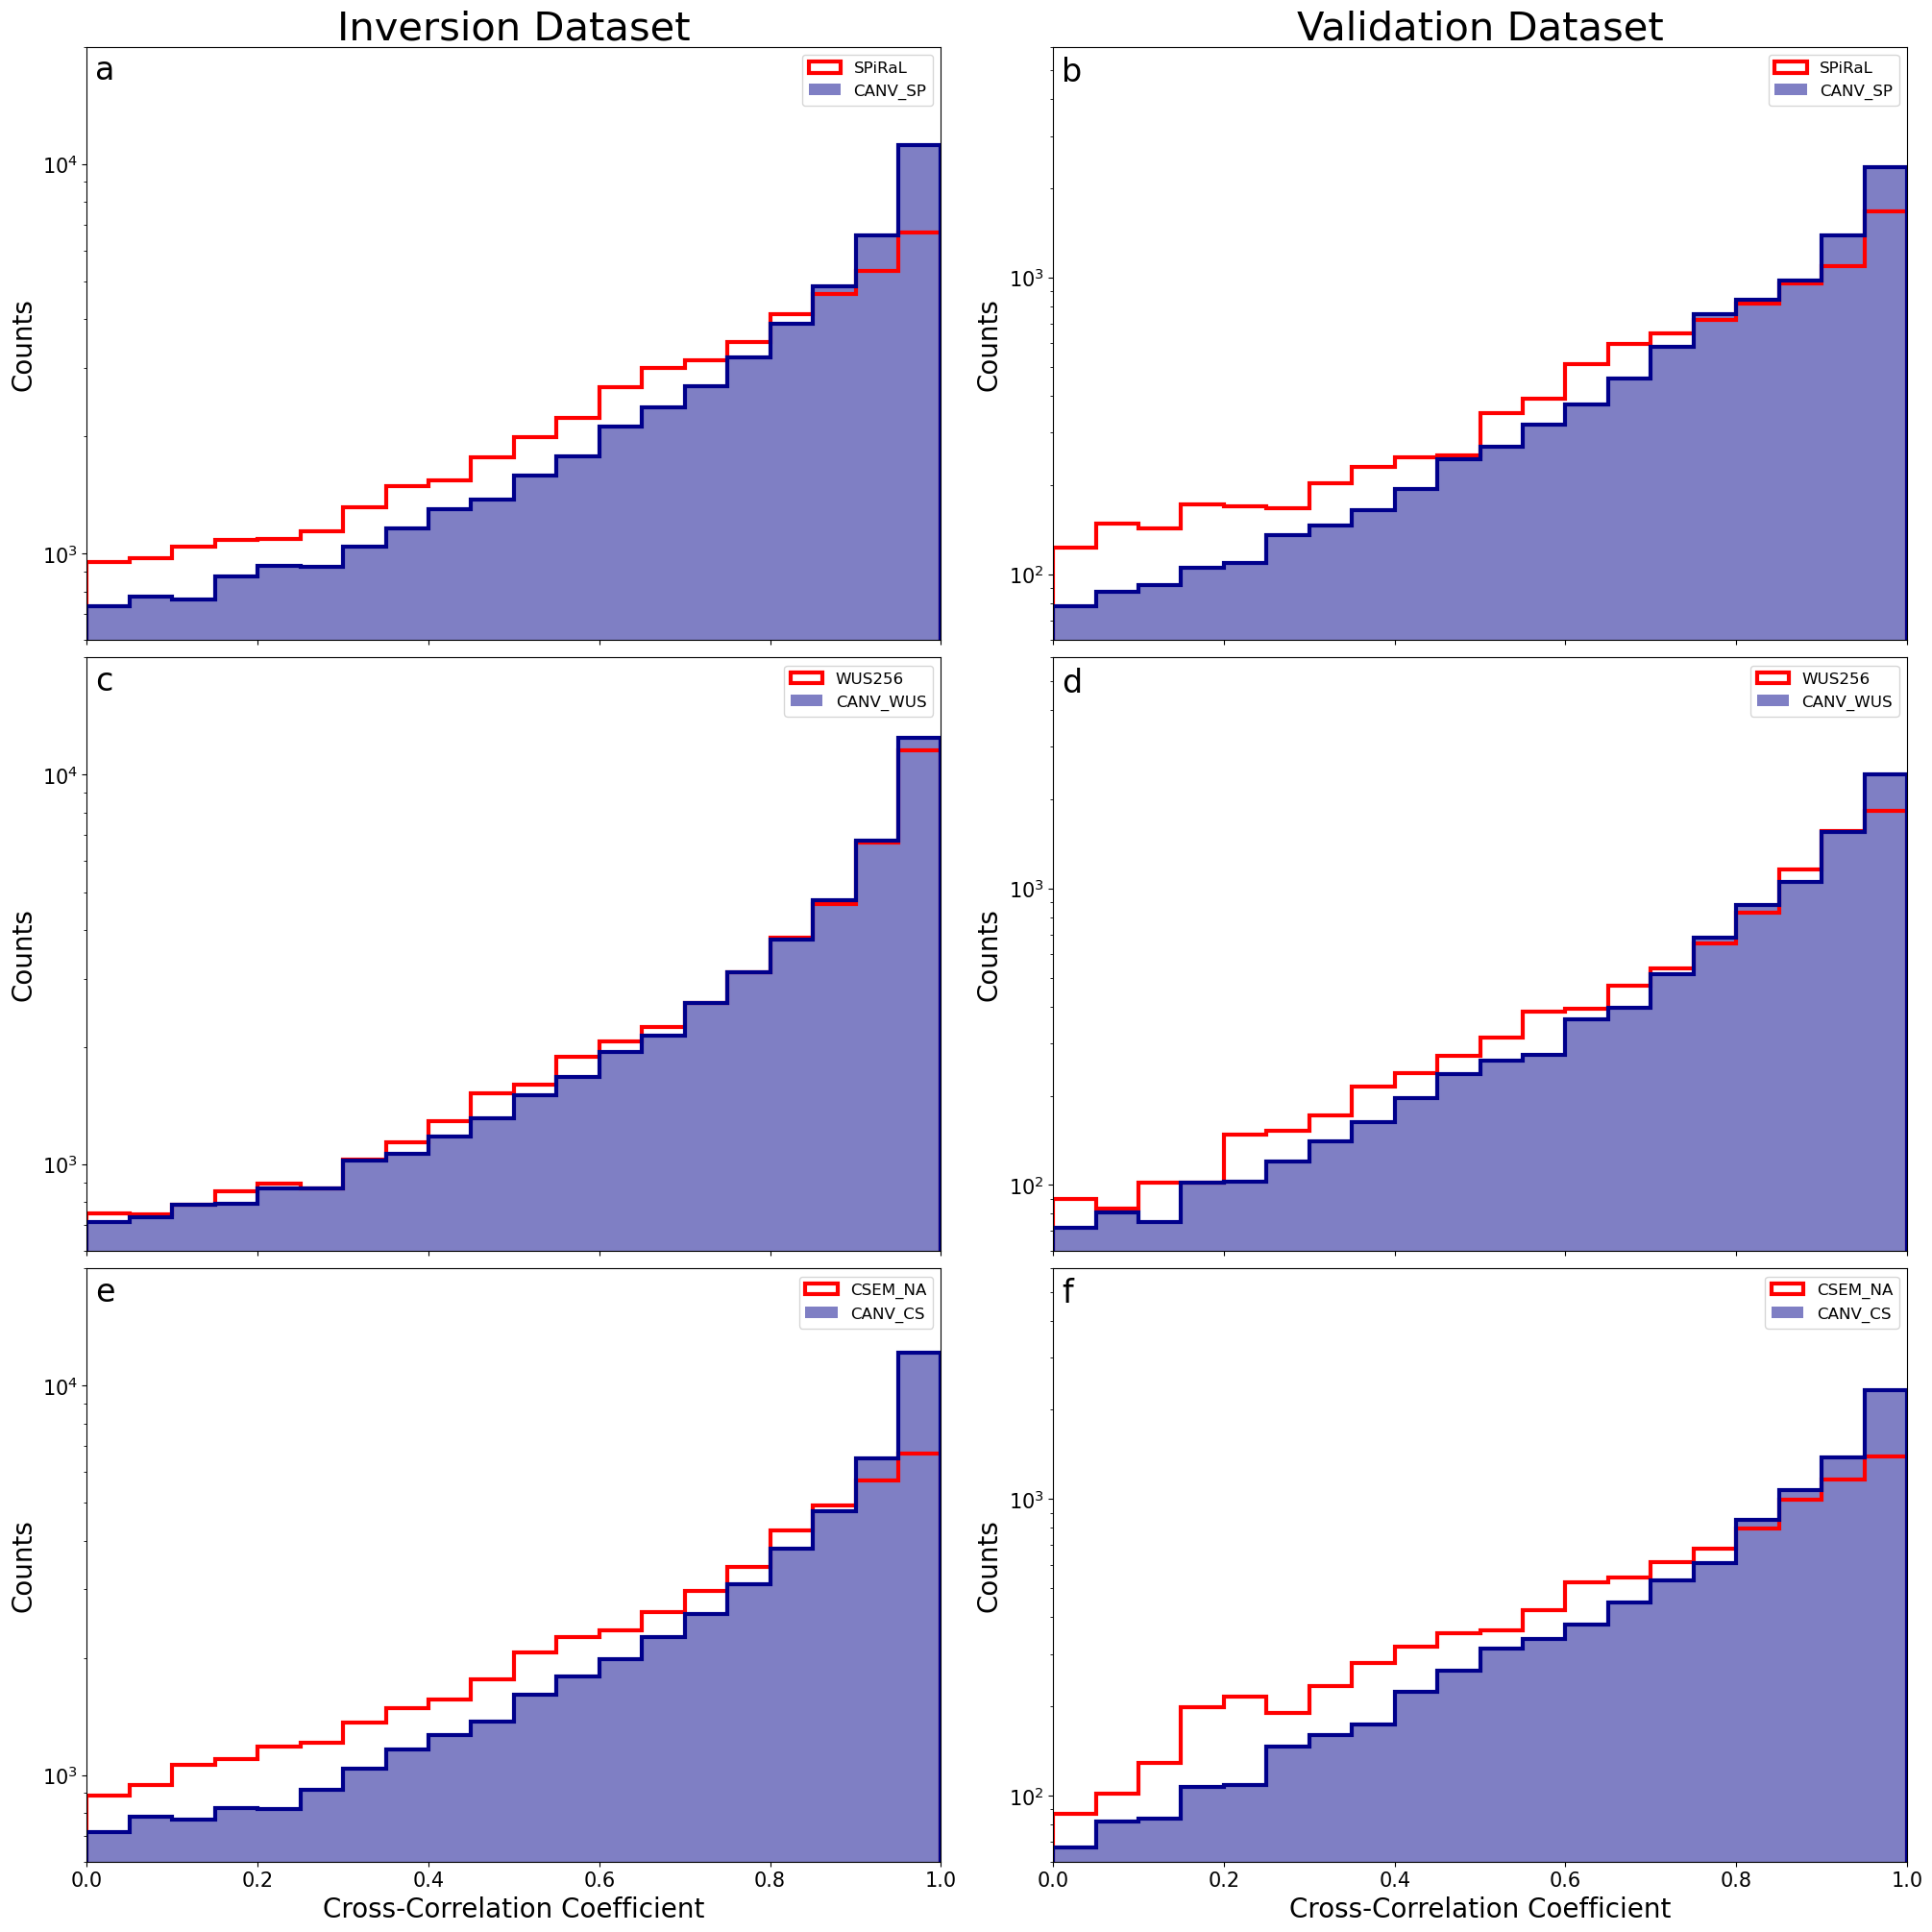

In [26]:
bins = [0.0,0.05, 0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,
        0.70,0.75,0.80,0.85,0.90,0.95, 1.0]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

fig, ([ax0,ax1],[ax2,ax3], [ax4, ax5]) = plt.subplots(ncols = 2, nrows=3, figsize = (20,20), 
                                                    sharex = 'col', constrained_layout = True)

ax0.hist(sp_xcorrs,bins, label = 'SPiRaL', color = 'red', histtype = 'step', linewidth = 3,
         log = True)
ax0.hist(cnsp_xcorrs, bins, color='darkblue', histtype = 'step',linewidth = 3,
        log = True)
ax0.hist(cnsp_xcorrs, bins, label='CANV_SP', color='darkblue', alpha = 0.5, log = True)
ax0.text(0.01, 16500, 'a', fontsize = 24)

ax0.set_xlim([0,1])
ax0.set_title('Inversion Dataset', fontsize = 30)
#ax0.set_yscale('log')
ax0.set_ylim([600,20000])
ax0.set_ylabel('Counts', fontsize = 20)
#ax0.text(x = 0.02, y = 18000, s = 'a')
ax0.legend(fontsize = 12, loc = 'upper right')

ax2.hist(wus_xcorrs,bins, label = 'WUS256', color = 'red', histtype = 'step', linewidth = 3,
         log = True)
ax2.hist(cnws_xcorrs, bins, label='CANV_WUS', color='darkblue', alpha = 0.5, log = True)
ax2.hist(cnws_xcorrs, bins, color='darkblue', histtype = 'step',linewidth = 3, log = True)
ax2.text(0.01, 16500, 'c', fontsize = 24)

ax2.set_xlim([0,1])
ax2.set_ylim([600,20000])
ax2.set_ylabel('Counts', fontsize = 20)
ax2.legend(fontsize = 12, loc = 'upper right')

ax4.hist(cs_xcorrs,bins, label = 'CSEM_NA', color = 'red', histtype = 'step', linewidth = 3,
         log = True)
ax4.hist(cncs_xcorrs, bins, label='CANV_CS', color='darkblue', alpha = 0.5, log = True)
ax4.hist(cncs_xcorrs, bins, color='darkblue', histtype = 'step',linewidth = 3, log = True)
ax4.text(0.01, 16500, 'e', fontsize = 24)

ax4.set_xlim([0,1])
ax4.set_xlabel('Cross-Correlation Coefficient', fontsize = 20)
ax4.set_ylim([600,20000])
ax4.set_ylabel('Counts', fontsize = 20)
ax4.legend(fontsize = 12, loc = 'upper right')

ax1.hist(sp_xcorrs_val,bins, label = 'SPiRaL', color = 'red', histtype = 'step', linewidth = 3,
         log = True)
ax1.hist(cnsp_xcorrs_val, bins, label='CANV_SP', color='darkblue', alpha = 0.5, log = True)
ax1.hist(cnsp_xcorrs_val, bins, color='darkblue', histtype = 'step',linewidth = 3, log = True)
ax1.text(0.01, 4600, 'b', fontsize = 24)

ax1.set_xlim([0,1])
ax1.set_title('Validation Dataset', fontsize = 30)
ax1.set_ylim([60,6000])
ax1.set_ylabel('Counts', fontsize = 20)
ax1.legend(fontsize = 12, loc = 'upper right')


ax3.hist(wus_xcorrs_val,bins, label = 'WUS256', color = 'red', histtype = 'step', linewidth = 3,
         log = True)
ax3.hist(cnws_xcorrs_val, bins, label='CANV_WUS', color='darkblue', alpha = 0.5, log = True)
ax3.hist(cnws_xcorrs_val, bins, color='darkblue', histtype = 'step',linewidth = 3, log = True)
ax3.text(0.01, 4600, 'd', fontsize = 24)

ax3.set_xlim([0,1])
ax3.set_ylim([60,6000])
ax3.set_ylabel('Counts', fontsize = 20)
ax3.legend(fontsize = 12, loc = 'upper right')

ax5.hist(cs_xcorrs_val,bins, label = 'CSEM_NA', color = 'red', histtype = 'step', linewidth = 3,
         log = True)
ax5.hist(cncs_xcorrs_val, bins, label='CANV_CS', color='darkblue', alpha = 0.5, log = True)
ax5.hist(cncs_xcorrs_val, bins, color='darkblue', histtype = 'step',linewidth = 3, log = True)
ax5.text(0.01, 4600, 'f', fontsize = 24)

ax5.set_xlim([0,1])
ax5.set_xlabel('Cross-Correlation Coefficient', fontsize = 20)
ax5.set_ylim([60,6000])
ax5.set_ylabel('Counts', fontsize = 20)
ax5.legend(fontsize = 12, loc = 'upper right')


plt.savefig('Figure9_env_xcorr.png')

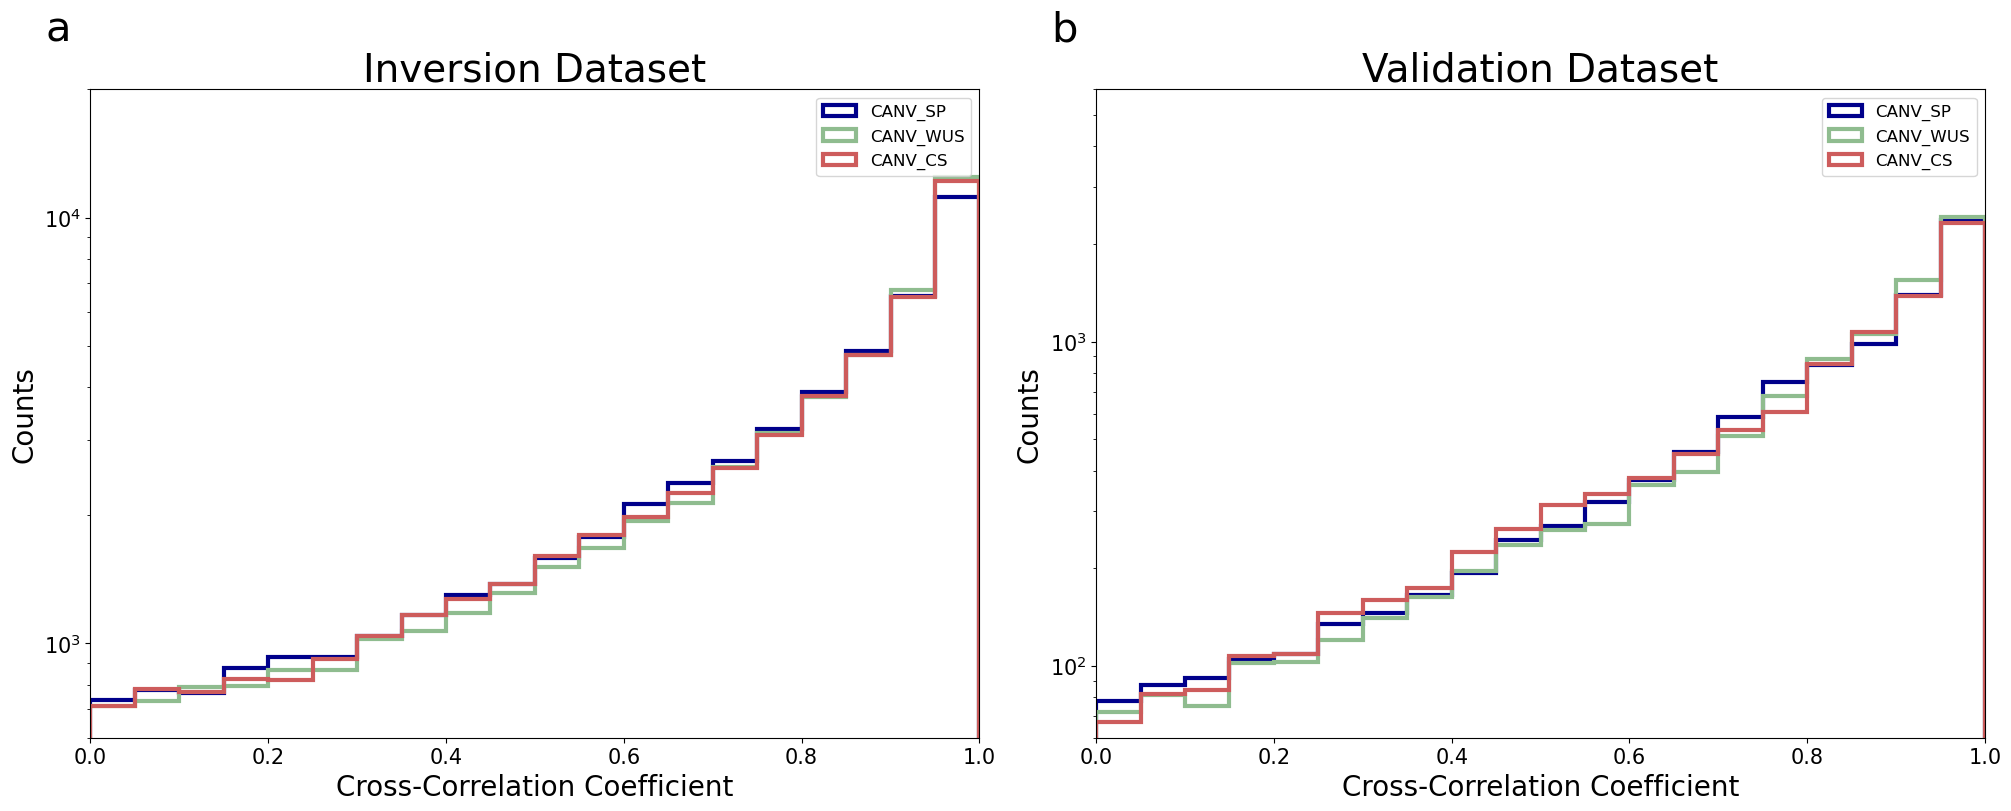

In [46]:
bins = [0.0,0.05, 0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,
        0.70,0.75,0.80,0.85,0.90,0.95, 1.0]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

fig, ([ax0,ax1]) = plt.subplots(ncols = 2, nrows=1, figsize = (20,8), 
                                                    sharex = 'col', constrained_layout = True)

ax0.hist(cnsp_xcorrs, bins, color='darkblue', histtype = 'step',linewidth = 3,
        label = 'CANV_SP',log = True)
ax0.hist(cnws_xcorrs, bins, color='darkseagreen', label = 'CANV_WUS', histtype = 'step',linewidth = 3, log = True)
ax0.hist(cncs_xcorrs, bins, color='indianred', label = 'CANV_CS',histtype = 'step',linewidth = 3, log = True)
#ax0.hist(cnsp_xcorrs, bins, label='CANV_SP', color='darkblue', alpha = 0.5, log = True)
#ax2.hist(cnws_xcorrs, bins, label='CANV_WUS', color='darkblue', alpha = 0.5, log = True)
#ax4.hist(cncs_xcorrs, bins, label='CANV_CS', color='darkblue', alpha = 0.5, log = True)
ax0.text(-0.05, 26000, 'a', fontsize = 30)

ax0.set_xlim([0,1])
ax0.set_title('Inversion Dataset', fontsize = 28)
#ax0.set_yscale('log')
ax0.set_ylim([600,20000])
ax0.set_ylabel('Counts', fontsize = 20)
ax0.set_xlabel('Cross-Correlation Coefficient', fontsize = 20)
ax0.legend(fontsize = 12, loc = 'upper right')

#ax1.hist(cnsp_xcorrs_val, bins, label='CANV_SP', color='darkblue', alpha = 0.5, log = True)
ax1.hist(cnsp_xcorrs_val, bins, color='darkblue', label = 'CANV_SP',histtype = 'step',linewidth = 3, log = True)
#ax3.hist(cnws_xcorrs_val, bins, label='CANV_WUS', color='darkblue', alpha = 0.5, log = True)
ax1.hist(cnws_xcorrs_val, bins, color='darkseagreen', label = 'CANV_WUS',histtype = 'step',linewidth = 3, log = True)
#ax1.hist(cncs_xcorrs_val, bins, label='CANV_CS', color='darkblue', alpha = 0.5, log = True)
ax1.hist(cncs_xcorrs_val, bins, color='indianred', label = 'CANV_CS',histtype = 'step',linewidth = 3, log = True)
ax1.text(-0.05, 8500, 'b', fontsize = 30)

ax1.set_xlim([0,1])
ax1.set_title('Validation Dataset', fontsize = 28)
ax1.set_ylim([60,6000])
ax1.set_ylabel('Counts', fontsize = 20)
ax1.set_xlabel('Cross-Correlation Coefficient', fontsize = 20)
ax1.legend(fontsize = 12, loc = 'upper right')


plt.savefig('Figure9_env_xcorr_final_model_comp.png')
#plt.show()

In [3]:
p = sn.Project(path = 'Validation')

Accordion(children=(HTML(value='\n                <head>\n                <style>\n                td {\n     …

In [4]:
def grab_event_data_val(event_name):
    event_name = event_name

    data_processing_config_name = "20_80_seconds"
    data = p.waveforms.get(data_name='PROCESSED_DATA:'+data_processing_config_name, events=event_name)

    # #SPiRaL Initial Model
    simulation_config_name = 'spiral'
    spiral = p.waveforms.get(data_name=simulation_config_name, events=event_name)

    # #WUS_AWT
    simulation_config_name = 'wus'
    wus256 = p.waveforms.get(data_name=simulation_config_name, events=event_name)
    
    #CSEM
    simulation_config_name = 'csem'
    csem = p.waveforms.get(data_name=simulation_config_name, events=event_name)

    #CANV_SP
    simulation_config_name = 'canv_sp'
    canv_sp = p.waveforms.get(data_name= simulation_config_name, events=event_name)

    #CANV256
    simulation_config_name = 'canv_wus'
    canv_wus = p.waveforms.get(data_name=simulation_config_name, events=event_name)
    
    #CANV_CS
    simulation_config_name = 'canv_cs'
    canv_cs = p.waveforms.get(data_name=simulation_config_name, events=event_name)
    
    return data, spiral, wus256, csem, canv_sp, canv_wus, canv_cs

In [16]:
def create_streams_val(event_name, sta_lat, sta_lon, st, st_name, filter_wfs, snr_calc, wf_return):
    from obspy.core import UTCDateTime
    """
    Plot data and two sets of synthetic waveforms (3-components)
    Inputs:
        event = Salvus event object
        st = data stream
        st1 = 1st synthetic stream, e.g. starting model
        st2 = 2nd synthetic stream, e.g. inversion model
        Assumes the streams are for the same event and receiver and have all 3 components
    """
    
    event = p.events.get(event_name=event_name)
    max_period = 80
    min_period = 20
    filter_wfs = True
    filter_period = 80
    if filter_wfs:
        max_period = filter_period
    
    eve_meta = event.sources[0]._initial_arguments
    eve_lat = eve_meta['latitude']
    eve_lon = eve_meta['longitude']
    
    azi = gps2dist_azimuth(sta_lat,sta_lon, eve_lat,eve_lon)
    bazi = azi[2]
    
    # Origin time
    origin_time = UTCDateTime(event.sources[0]._initial_arguments['reference_time_utc_string'])
    
    # Interpolate waveforms to common sample_Rate
    target_sps = 2
    st.interpolate(sampling_rate=target_sps)

    # Additional highpass filter
    if filter_wfs:
        st.filter(type='bandpass', freqmin=1/filter_period, freqmax=1/min_period)
    t0 = origin_time
    t1 = origin_time + azi[0]/8500.
    t2 = origin_time + azi[0]/8000.
    t3 = origin_time + azi[0]/2500.
    
    # Arrange order of stream components to ZNE
    st = st.select(component="Z") + st.select(component="N") + st.select(component="E")

    # Scale amplitudes from meters to micrometers
    for tr in st:
        tr.data = tr.data * 1.0e6
        tr.stats.distance = azi[0]/1000. #distance in km

    st.rotate(method = 'NE->RT', back_azimuth = bazi)
    min_freq = 1./max_period
    
    if snr_calc:
        for tr in st:
            if tr.stats.channel == 'BHR' or 'HHR':
                p2pn = peak_to_peak(tr.slice(origin_time, t1), min_freq)
                p2ps = peak_to_peak(tr.slice(t2, t3), min_freq)
                snr = 10*np.log10(p2ps**2/p2pn**2)
                if snr >=10.0:
                    SNR[sncl] = snr, [sta_lat, sta_lon]
        return SNR
    if wf_return:
        # Cut waveforms to tmax
        stream = st_name
        for tr in st:
            stream.append(tr)
        stream = stream.slice(starttime=t2, endtime=t3)
        return stream

In [17]:
wus_xcorrs_val = []
cnws_xcorrs_val = []

sp_xcorrs_val = []
cnsp_xcorrs_val = []

cs_xcorrs_val = []
cncs_xcorrs_val = []

for event_name in p.events.list():
    print(event_name)
    data, spiral, wus256, csem, canv_sp, canv_wus, canv_cs = grab_event_data_val(event_name)
    
    sta_lats = []
    sta_lons = []
    sncls = []
    for  idx in np.arange(0, len(data[0].receiver_name_list), 1):   
        sta = data[0].receivers[idx].to_json()
        args = sta['arguments']
        sta_lat = sta_lat = converted_latitude = (
        # This function defaults to the WGS84 ellipsoid but others are possible.
        sn.simple_config.coordinate_system_utils._geocentric_to_elliptic_latitude(
            lat=args['latitude']
        )
    )
        sta_lon = args['longitude']
        sta_lats.append(sta_lat)
        sta_lons.append(sta_lon)

        sncl = str(args['network_code']+'.'+ args['station_code']+'.')
        sncls.append(sncl)

    SNR = {}

    for sncl in sncls:
        try:
            st_data = data[0].get_receiver_data(receiver_name=sncl, 
                                                receiver_field='displacement')
            SNR = create_streams_val(event_name, sta_lat, sta_lon, st_data, obs, True, True, False)
        except:
            pass

    st_sp = op.Stream()
    st_cnsp = op.Stream()
    st_wus = op.Stream()
    st_cnws = op.Stream()
    st_cs = op.Stream()
    st_cncs = op.Stream()
    obs = op.Stream()


    for key, value in SNR.items():
        sta_lat = value[1][0]
        sta_lon = value[1][1]
        
        try:

            st_start_s = spiral[0].get_receiver_data(receiver_name=key, 
                                                     receiver_field='displacement')
            st_final_s = canv_sp[0].get_receiver_data(receiver_name=key, 
                                                      receiver_field='displacement')
            st_start_w = wus256[0].get_receiver_data(receiver_name=key, 
                                                     receiver_field='displacement')
            st_final_w = canv_wus[0].get_receiver_data(receiver_name=key, 
                                                       receiver_field='displacement')
            st_start_c = csem[0].get_receiver_data(receiver_name=key, 
                                                   receiver_field='displacement')
            st_final_c = canv_cs[0].get_receiver_data(receiver_name=key, 
                                                      receiver_field='displacement')
            st_data = data[0].get_receiver_data(receiver_name=key, 
                                                receiver_field='displacement')

            st_sp = create_streams_val(event_name, sta_lat, sta_lon, st_start_s, st_sp, 
                                   True, False, True)
            st_cnsp = create_streams_val(event_name, sta_lat, sta_lon, st_final_s, st_cnsp,
                                    True, False, True)
            st_wus = create_streams_val(event_name, sta_lat, sta_lon, st_start_w, st_wus, 
                                    True, False, True)
            st_cnws = create_streams_val(event_name, sta_lat, sta_lon, st_final_w, st_cnws, 
                                     True, False, True)
            st_cs = create_streams_val(event_name, sta_lat, sta_lon, st_start_c, st_cs, 
                                   True, False, True)
            st_cncs = create_streams_val(event_name, sta_lat, sta_lon, st_final_c, st_cncs, 
                                     True, False, True)
            obs = create_streams_val(event_name, sta_lat, sta_lon, st_data, obs, 
                                 True, False, True)
        except:
            print('SPiRaL Issue')
            
   # print(len(st_sp), len(st_cnsp), len(st_wus), len(st_cnws), len(st_cs), len(st_cncs))

#     if len(obs) != len(st_sp):
#         n = len(st_sp)-len(obs)
#         if n != 0:
#             n = len(st_sp)-len(obs)
#             for idx in np.arange(0, len(obs)):
#                 if obs[idx].id[:-4] == st_wus[idx].id[:-4]:
#                     pass
#                 else:
#                     st_sp.remove(st_sp[idx])
#                     st_cnsp.remove(st_cnsp[idx])
#                     st_wus.remove(st_wus[idx])
#                     st_cnws.remove(st_cnws[idx])
#                     st_cs.remove(st_cs[idx])
#                     st_cncs.remove(st_cncs[idx])
#                     break
    
    for idx in np.arange(0, len(st_sp)):
        try:
            envelope_xcorr(obs[idx], st_sp[idx], st_cnsp[idx], sp_xcorrs_val, cnsp_xcorrs_val)
            envelope_xcorr(obs[idx], st_wus[idx], st_cnws[idx], wus_xcorrs_val, cnws_xcorrs_val)
            envelope_xcorr(obs[idx], st_cs[idx], st_cncs[idx], cs_xcorrs_val, cncs_xcorrs_val)
        #print('Done!')
        except:
            print('ValueError: operands could not be broadcast together with mismatched shapes')

event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_4.77_2021-03-31-08-56


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_5.30_2021-06-05-17-56


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
/Users/claired/anaconda3/envs/salgmt/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_4.87_2020-12-03-05-15


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_4.87_2022-01-06-00-28


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_4.92_2020-12-14-21-20


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_4.99_2020-12-01-23-33


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs 

ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs 

 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


event_CALIFORNIA-NEVADA_BORDER_REGION_Mag_5.95_2021-07-08-22-49


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


event_CENTRAL_CALIFORNIA_Mag_4.84_2021-10-25-23-42


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


event_NEAR_COAST_OF_NORTHERN_CALIF._Mag_4.72_2022-01-06-02-42


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs 

ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs or NaNs
ValueError: array must not contain infs 

 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


event_NEAR_COAST_OF_NORTHERN_CALIF._Mag_6.21_2021-12-20-20-10


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


event_NEVADA_Mag_4.76_2021-08-31-17-21


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


event_NEVADA_Mag_5.41_2020-11-13-09-13


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


event_NORTHERN_CALIFORNIA_Mag_4.71_2021-05-07-04-35


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


In [18]:
print(wus_xcorrs_val)

[0.6321056005577695, -0.7000959536845315, -0.02356122408519032, 0.5211220444944604, 0.9559769181578446, 0.7450416726692198, 0.5990317028681383, 0.8017339645453926, 0.8722196568310197, 0.5742320547266514, -0.38361817837102885, 0.8444652405711361, 0.2795903612299592, 0.8314159594420155, -0.8315373342065752, 0.6713859628200932, 0.9892058025466871, 0.9050450939460334, 0.5579916281509375, 0.8733115916739159, -0.5182566376764584, 0.6193731258081955, 0.23252472118919146, 0.9293895585793753, 0.5011458542211319, 0.501449339288724, 0.6076316563473012, 0.6638533362583972, -0.17483090050839847, 0.17501314705939433, 0.9426080319720199, 0.8872767602058524, 0.5738558117011153, 0.8179654308667014, 0.9384822630422334, 0.4894311789433632, -0.8483535969362331, 0.43662628636694206, -0.5090268611013875, 0.5872696317304024, 0.3942462487158065, 0.5826335042386814, 0.7249102995759775, 0.9423130576938321, 0.6709255962852451, 0.8216972969062682, 0.9215176896696046, -0.19228410124111112, 0.9196644334959023, 0.93

In [19]:
import pandas as pd

df = pd.DataFrame([sp_xcorrs_val, wus_xcorrs_val, cs_xcorrs_val, cnsp_xcorrs_val, cnws_xcorrs_val, cncs_xcorrs_val])

df.to_csv('Validation_Evelope_xcorr_Vals.csv')

In [1]:
import pandas as pd

df = pd.read_csv('Validation_Evelope_xcorr_Vals.csv')

sp_xcorrs_val = []
wus_xcorrs_val = []
cs_xcorrs_val = []
cnsp_xcorrs_val = []
cnws_xcorrs_val = []
cncs_xcorrs_val = []

for row in range(0,6):
    for col in range(0, 10398):
        value = df.loc[row,str(col)]
        if row == 0:
            sp_xcorrs_val.append(value)
        elif row == 1:
            wus_xcorrs_val.append(value)
        elif row == 2:
            cs_xcorrs_val.append(value)
        elif row == 3:
            cnsp_xcorrs_val.append(value)
        elif row == 4:
            cnws_xcorrs_val.append(value)
        else:
            cncs_xcorrs_val.append(value)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


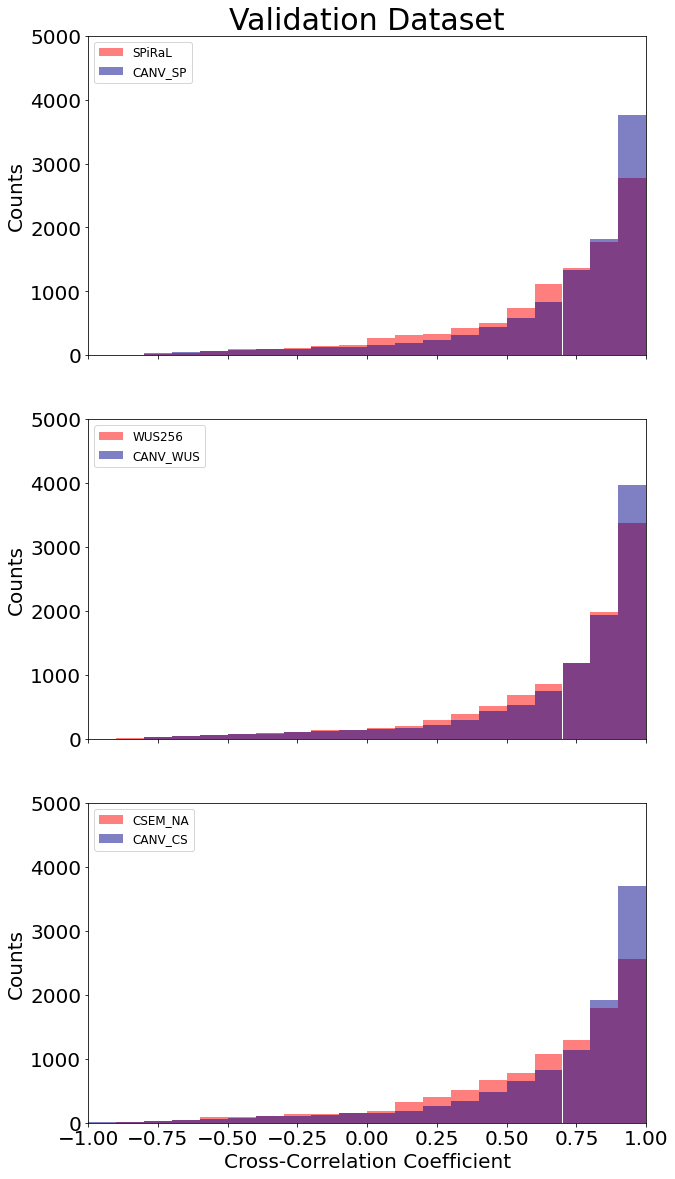

In [4]:
import matplotlib.pyplot as plt
import numpy as np

bins = [-1,-0.9,-0.80,-0.70,-0.60,-0.50,-0.40,-0.30,-0.20,-0.10,0
        ,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90, 1.0]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

fig, [ax1,ax3, ax5] = plt.subplots(ncols = 1, nrows=3, figsize = (10,20), 
                                                    sharex = 'col')

ax1.hist(sp_xcorrs_val,bins, label = 'SPiRaL', color = 'red', alpha = 0.5)
ax1.hist(cnsp_xcorrs_val, bins, label='CANV_SP', color='darkblue', alpha = 0.5)

ax1.set_xlim([-1,1])
ax1.set_title('Validation Dataset', fontsize = 30)
ax1.set_ylim([0,5000])
ax1.set_ylabel('Counts')
ax1.legend(fontsize = 12, loc = 'upper left')


ax3.hist(wus_xcorrs_val,bins, label = 'WUS256', color = 'red', alpha = 0.5)
ax3.hist(cnws_xcorrs_val, bins, label='CANV_WUS', color='darkblue', alpha = 0.5)

ax3.set_xlim([-1,1])
ax3.set_ylim([0,5000])
ax3.set_ylabel('Counts')
ax3.legend(fontsize = 12, loc = 'upper left')

ax5.hist(cs_xcorrs_val,bins, label = 'CSEM_NA', color = 'red', alpha = 0.5)
ax5.hist(cncs_xcorrs_val, bins, label='CANV_CS', color='darkblue', alpha = 0.5)

ax5.set_xlim([-1,1])
ax5.set_xlabel('Cross-Correlation Coefficient')
ax5.set_ylim([0,5000])
ax5.set_ylabel('Counts')
ax5.legend(fontsize = 12, loc = 'upper left')


plt.savefig('validation_data_env_xcorr.png')